In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

data = np.genfromtxt('/content/drive/MyDrive/SDT/gt_2015.csv', skip_header=1, delimiter=',', usecols=(0, 3, 8, 9, 10))

data_clean = data[~np.isnan(data).any(axis=1)]

Y = torch.from_numpy(data_clean[:, [3,4]]).float()
X = np.hstack((np.ones((data_clean.shape[0], 1)), data_clean[:, [0, 1, 2]]))
X_tensor = torch.from_numpy(X).float()

print("Shape of X:", X_tensor.shape)

print("Shape of Y:", Y.shape)

Shape of X: torch.Size([7384, 4])
Shape of Y: torch.Size([7384, 2])


In [3]:
class LinearRegression(nn.Module):
  def __init__(self, dimension_input, dimension_output):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(dimension_input, dimension_output)
  def forward(self, x):
    return self.linear(x)

dimension_input = X_tensor.shape[1]
dimension_output = Y.shape[1]

model = LinearRegression(dimension_input, dimension_output)

print(model)

LinearRegression(
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


In [4]:
loss_function = nn.MSELoss()
learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print("Loss_function:", loss_function)
print(f"Optimizer:{optimizer}")

Loss_function: MSELoss()
Optimizer:SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [5]:
# Compute the closed-form solution using the normal equation
X_T_X = X_tensor.T @ X_tensor
X_T_Y = X_tensor.T @ Y
B_closed = torch.inverse(X_T_X) @ X_T_Y

# Compute predictions using the closed-form solution
Y_pred_closed = X_tensor @ B_closed

# Compute the MSE for the closed-form solution
MSE_closed = loss_function(Y_pred_closed, Y).item()

# Print the closed-form solution and its MSE
print("Closed-form solution (B_closed):\n", B_closed)
print(f"Mean Squared Error (MSE) using closed-form solution: {MSE_closed:.4f}")


Closed-form solution (B_closed):
 tensor([[ 1.8203e+01,  9.4398e+01],
        [-8.1696e-02, -5.5624e-01],
        [ 2.1198e-01, -7.4893e+00],
        [-1.1928e+00,  1.6748e-01]])
Mean Squared Error (MSE) using closed-form solution: 34.0582


In [6]:
# Set the number of epochs (iterations)
epochs = 1000  # You can adjust this based on your needs

# Initialize an array to store the loss at each epoch
losses = []

for epoch in range(epochs):
    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Forward pass: compute predicted Y by passing X to the model
    Y_pred = model(X_tensor)

    # Compute the loss
    loss = loss_function(Y_pred, Y)

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Update model parameters
    optimizer.step()

    # Store the loss value for comparison later
    losses.append(loss.item())

    # Print the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Print final loss
print(f'Final Loss after Gradient Descent: {losses[-1]:.4f}')

# Compare final MSE from gradient descent with the closed-form MSE
print(f"Closed-form MSE: {MSE_closed:.4f}")
print(f"Final MSE after Gradient Descent: {losses[-1]:.4f}")


Epoch [100/1000], Loss: 250.0823
Epoch [200/1000], Loss: 198.3950
Epoch [300/1000], Loss: 163.7311
Epoch [400/1000], Loss: 140.4537
Epoch [500/1000], Loss: 124.8133
Epoch [600/1000], Loss: 114.2951
Epoch [700/1000], Loss: 107.2123
Epoch [800/1000], Loss: 102.4337
Epoch [900/1000], Loss: 99.2006
Epoch [1000/1000], Loss: 97.0041
Final Loss after Gradient Descent: 97.0041
Closed-form MSE: 34.0582
Final MSE after Gradient Descent: 97.0041


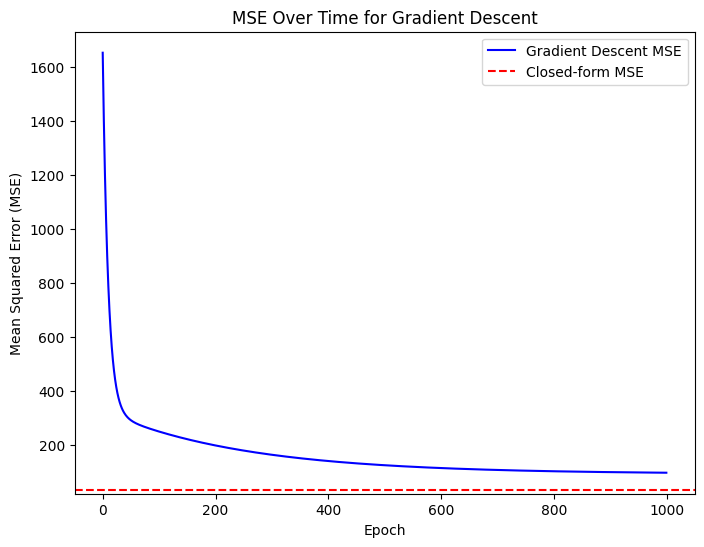

In [9]:
import matplotlib.pyplot as plt

# Plot the MSE over epochs from gradient descent
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Gradient Descent MSE', color='blue')

# Plot a horizontal line showing the closed-form MSE
plt.axhline(y=MSE_closed, color='red', linestyle='--', label='Closed-form MSE')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Over Time for Gradient Descent')
plt.legend()

# Display the plot
plt.show()
